# Task 2: Quantitative Analysis using PyNance and TA-Lib

## Overview
This notebook focuses on technical analysis of stock price data using PyNance and TA-Lib. We'll analyze historical stock data for major tech companies (AMZN, GOOG, META, MSFT, NVDA, TSLA) to understand price movements and market trends.

## The Objectives of this task:
1. Load and prepare stock price data
2. Calculate technical indicators (MA, RSI, MACD)
3. Visualize price movements and indicators
4. Understand the relationship between different technical indicators

In [19]:
# Environment Setup
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from datetime import datetime
import matplotlib

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Set plotting style
plt.style.use('seaborn')
sns.set_palette('husl')

# Print library versions for reproducibility
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")  # Corrected this line

pandas version: 2.0.3
numpy version: 1.24.4
matplotlib version: 3.7.1


/tmp/ipykernel_52694/2521548635.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Understanding the Data Structure

Before we begin our analysis, let's examine what data we have available and its structure. We'll:
1. List all available stock data files
2. Understand the data format
3. Check the data location

In [20]:
# List available stock data files
data_dir = '../data/raw/yfinance_data'
stock_files = [f for f in os.listdir(data_dir) if f.endswith('_historical_data.csv')]
print("Available stock data files:")
for file in stock_files:
    print(f"- {file}")

Available stock data files:
- NVDA_historical_data.csv
- MSFT_historical_data.csv
- GOOG_historical_data.csv
- AMZN_historical_data.csv
- META_historical_data.csv
- TSLA_historical_data.csv


## Loading and Initial Data Exploration

We'll start by loading the NVDA (NVIDIA) stock data as our first example. This will help us understand:
1. The data structure
2. Available columns
3. Date range
4. Basic statistics

In [21]:
# Load NVDA historical data
nvda_data = pd.read_csv(os.path.join(data_dir, 'NVDA_historical_data.csv'))

# Display basic information about the dataset
print("Dataset Information:")
print("-" * 50)
print(f"Number of rows: {nvda_data.shape[0]}")
print(f"Number of columns: {nvda_data.shape[1]}")
print(f"\nColumns in the dataset:")
for col in nvda_data.columns:
    print(f"- {col}")

# Display the first few rows
print("\nFirst 5 rows of the data:")
display(nvda_data.head())

Dataset Information:
--------------------------------------------------
Number of rows: 6421
Number of columns: 9

Columns in the dataset:
- Date
- Open
- High
- Low
- Close
- Adj Close
- Volume
- Dividends
- Stock Splits

First 5 rows of the data:


,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000,0.0,0.0
1,1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000,0.0,0.0
2,1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000,0.0,0.0
3,1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000,0.0,0.0
4,1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000,0.0,0.0


## Data Preprocessing

Before we can perform technical analysis, we need to preprocess our data. This involves:
1. Converting dates to datetime format
2. Setting the date as index
3. Sorting data chronologically
4. Checking for missing values
5. Verifying data types

In [22]:
# Convert date column to datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

# Set date as index and sort
nvda_data.set_index('Date', inplace=True)
nvda_data.sort_index(inplace=True)

# Check for missing values
print("Missing values per column:")
missing_values = nvda_data.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.any() else "No missing values found")

# Display data types and basic statistics
print("\nData Types:")
print(nvda_data.dtypes)
print("\nBasic Statistics:")
display(nvda_data.describe())

Missing values per column:
No missing values found

Data Types:
Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

Basic Statistics:


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
count,6421.000000,6421.000000,6421.000000,6421.000000,6421.000000,6.421000e+03,6421.000000,6421.000000
mean,6.207884,6.320466,6.085095,6.207702,6.181334,6.060791e+08,0.000025,0.003348
std,16.138328,16.424862,15.794914,16.118517,16.121352,4.323482e+08,0.000316,0.142397
min,0.034896,0.035547,0.033333,0.034115,0.031291,1.968000e+07,0.000000,0.000000
25%,0.277500,0.286250,0.269500,0.276750,0.253843,3.456350e+08,0.000000,0.000000
50%,0.457250,0.464750,0.450750,0.457000,0.427637,5.070000e+08,0.000000,0.000000
75%,4.182500,4.235750,4.116500,4.175000,4.130434,7.362000e+08,0.000000,0.000000
max,139.800003,140.759995,132.419998,135.580002,135.580002,9.230856e+09,0.010000,10.000000


## Basic Price Analysis

Let's start with a basic visualization of the stock price over time. We'll create:
1. A price chart showing the closing price
2. A volume chart showing trading activity
3. A combined visualization to see the relationship between price and volume

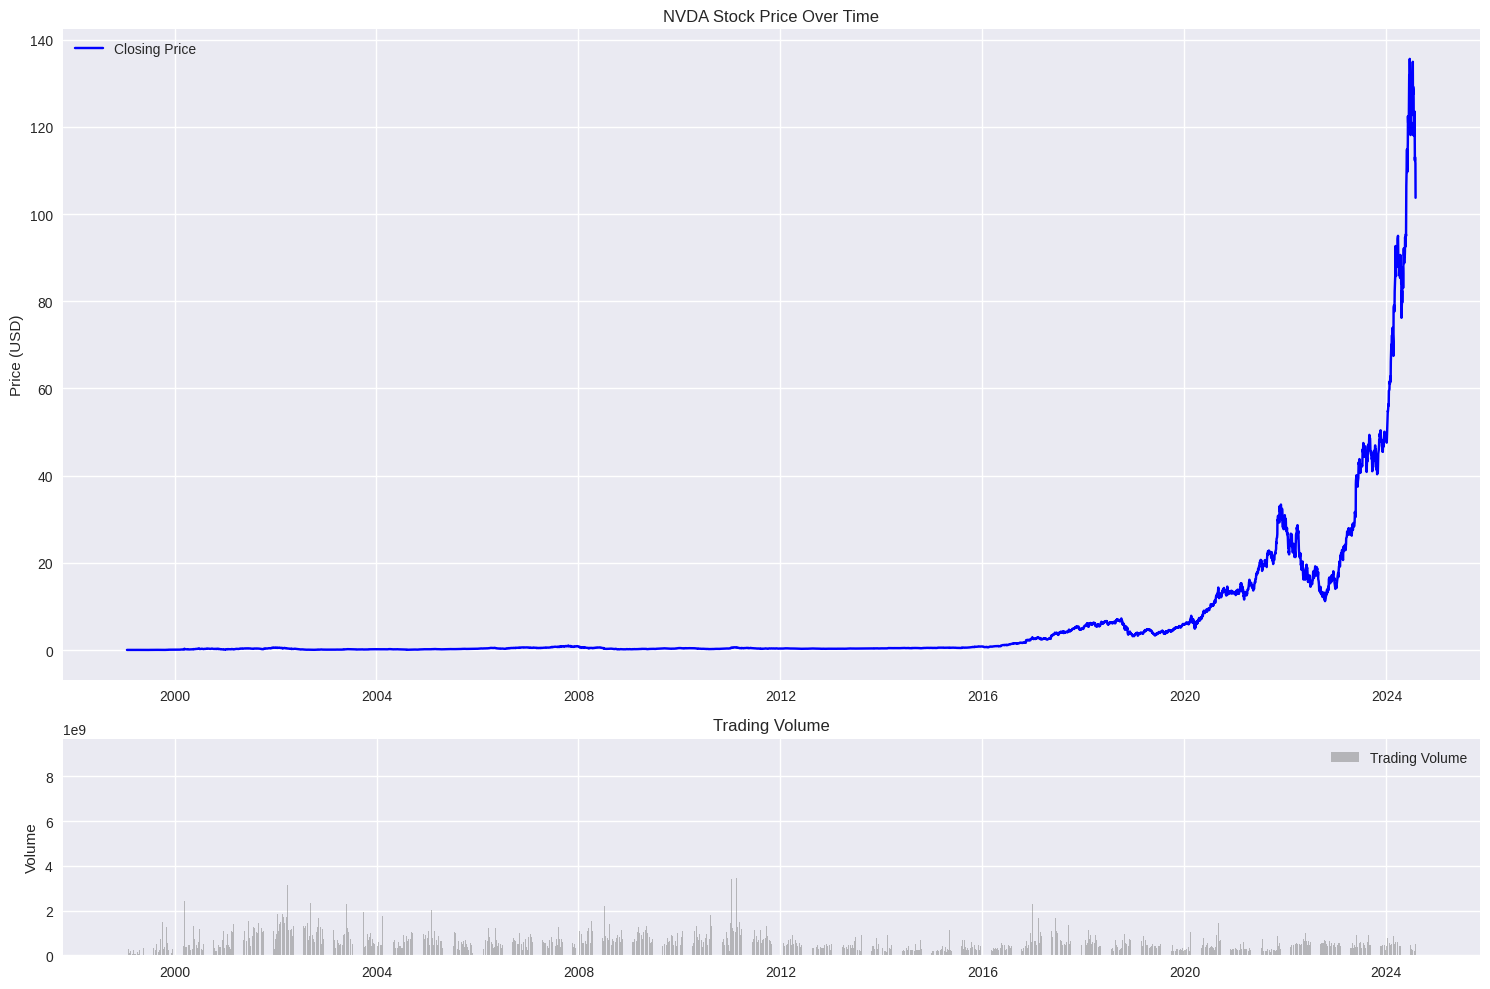


Price Statistics:
Highest Price: $140.76
Lowest Price: $0.03
Average Price: $6.21
Price Volatility (Std Dev): $16.12


In [23]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot closing price
ax1.plot(nvda_data.index, nvda_data['Close'], label='Closing Price', color='blue')
ax1.set_title('NVDA Stock Price Over Time')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# Plot trading volume
ax2.bar(nvda_data.index, nvda_data['Volume'], label='Trading Volume', color='gray', alpha=0.5)
ax2.set_title('Trading Volume')
ax2.set_ylabel('Volume')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate and display basic price statistics
print("\nPrice Statistics:")
print(f"Highest Price: ${nvda_data['High'].max():.2f}")
print(f"Lowest Price: ${nvda_data['Low'].min():.2f}")
print(f"Average Price: ${nvda_data['Close'].mean():.2f}")
print(f"Price Volatility (Std Dev): ${nvda_data['Close'].std():.2f}")

## Moving Averages Analysis

Moving Averages (MA) are one of the most popular technical indicators. They help:
1. Identify trends
2. Determine support and resistance levels
3. Generate trading signals

We'll calculate and plot:
- 20-day Simple Moving Average (SMA)
- 50-day Simple Moving Average (SMA)
- 200-day Simple Moving Average (SMA)

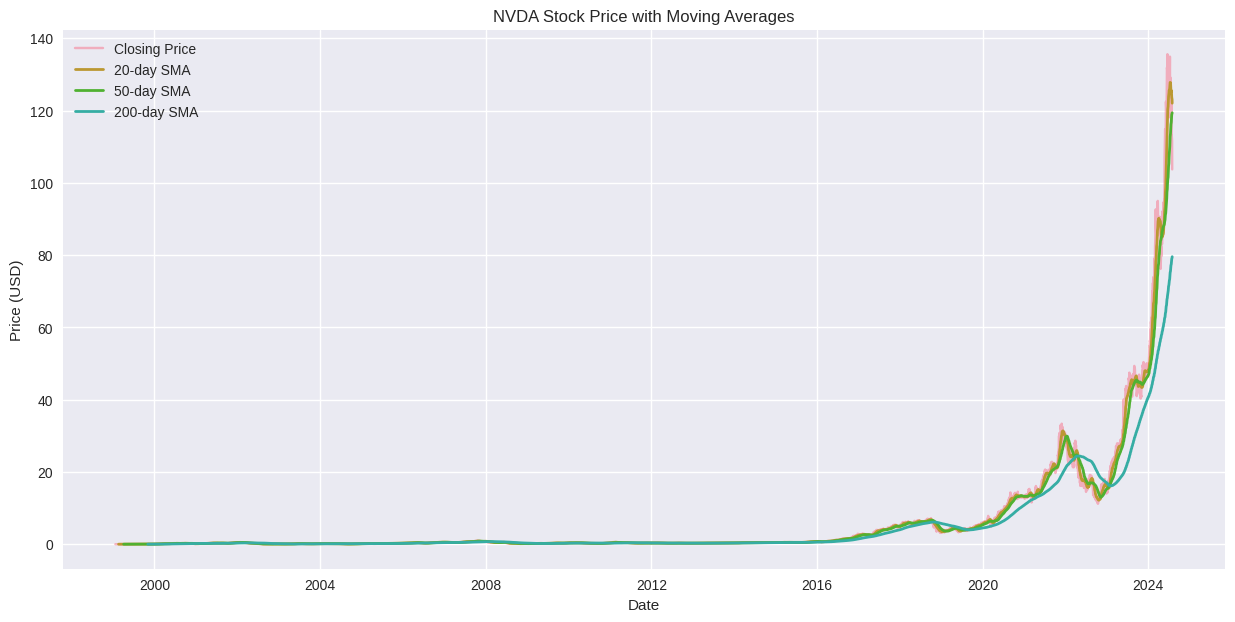


Latest Moving Average Values:


,Close,SMA_20,SMA_50,SMA_200
Date,,,,
2024-07-24,114.250000,124.9165,117.98118,78.288715
2024-07-25,112.279999,124.2105,118.41880,78.621305
2024-07-26,113.059998,123.6640,118.85288,78.960240
2024-07-29,111.589996,123.0665,119.19208,79.289200
2024-07-30,103.730003,122.0380,119.37950,79.573820


In [24]:
# Calculate different moving averages
nvda_data['SMA_20'] = talib.SMA(nvda_data['Close'], timeperiod=20)
nvda_data['SMA_50'] = talib.SMA(nvda_data['Close'], timeperiod=50)
nvda_data['SMA_200'] = talib.SMA(nvda_data['Close'], timeperiod=200)

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(nvda_data.index, nvda_data['Close'], label='Closing Price', alpha=0.5)
plt.plot(nvda_data.index, nvda_data['SMA_20'], label='20-day SMA', linewidth=2)
plt.plot(nvda_data.index, nvda_data['SMA_50'], label='50-day SMA', linewidth=2)
plt.plot(nvda_data.index, nvda_data['SMA_200'], label='200-day SMA', linewidth=2)

plt.title('NVDA Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Display the last few rows to see the moving averages
print("\nLatest Moving Average Values:")
display(nvda_data[['Close', 'SMA_20', 'SMA_50', 'SMA_200']].tail())

## Relative Strength Index (RSI) Analysis

The RSI is a momentum oscillator that measures the speed and change of price movements. It:
1. Ranges from 0 to 100
2. Helps identify overbought (>70) and oversold (<30) conditions
3. Can indicate potential trend reversals

We'll calculate and analyze the 14-day RSI, which is the standard period.

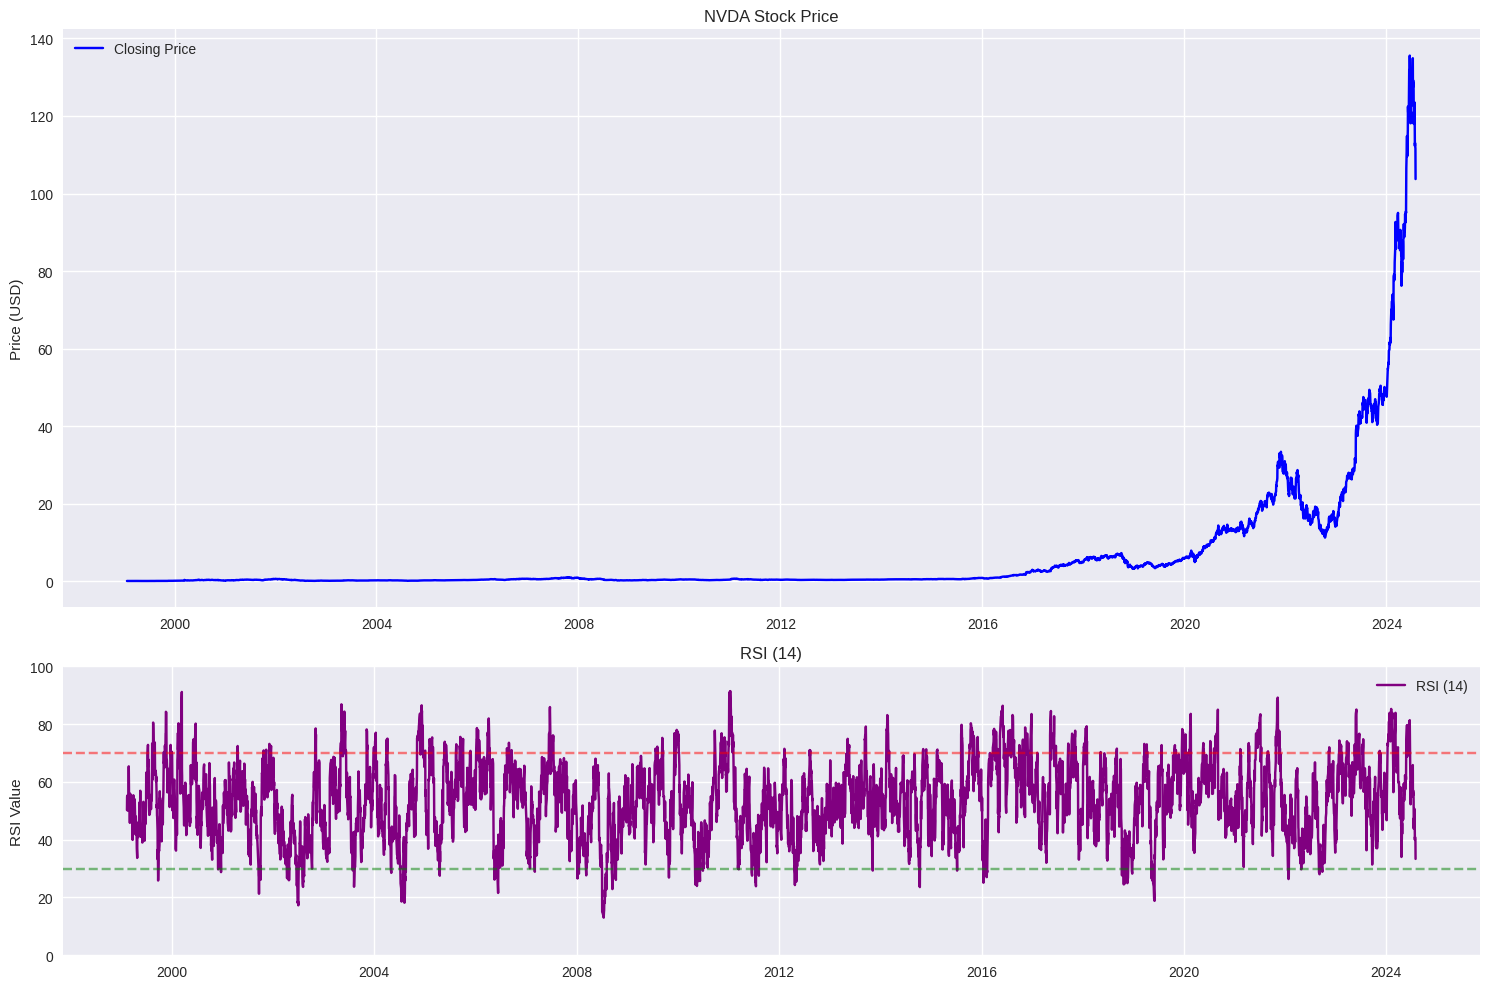


RSI Statistics:
Current RSI: 33.35
RSI Range: 13.03 to 91.42
RSI Mean: 53.60

Overbought conditions (RSI > 70): 694 days
Oversold conditions (RSI < 30): 193 days


In [25]:
# Calculate RSI
nvda_data['RSI_14'] = talib.RSI(nvda_data['Close'], timeperiod=14)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot price and RSI
ax1.plot(nvda_data.index, nvda_data['Close'], label='Closing Price', color='blue')
ax1.set_title('NVDA Stock Price')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# Plot RSI
ax2.plot(nvda_data.index, nvda_data['RSI_14'], label='RSI (14)', color='purple')
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
ax2.set_title('RSI (14)')
ax2.set_ylabel('RSI Value')
ax2.set_ylim(0, 100)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Display RSI statistics
print("\nRSI Statistics:")
print(f"Current RSI: {nvda_data['RSI_14'].iloc[-1]:.2f}")
print(f"RSI Range: {nvda_data['RSI_14'].min():.2f} to {nvda_data['RSI_14'].max():.2f}")
print(f"RSI Mean: {nvda_data['RSI_14'].mean():.2f}")

# Identify overbought and oversold conditions
overbought = nvda_data[nvda_data['RSI_14'] > 70]
oversold = nvda_data[nvda_data['RSI_14'] < 30]

print(f"\nOverbought conditions (RSI > 70): {len(overbought)} days")
print(f"Oversold conditions (RSI < 30): {len(oversold)} days")

## MACD (Moving Average Convergence Divergence) Analysis

MACD is a trend-following momentum indicator that shows the relationship between two moving averages. It consists of:
1. MACD Line: Difference between 12-day and 26-day EMAs
2. Signal Line: 9-day EMA of the MACD Line
3. Histogram: Difference between MACD and Signal lines

This helps identify:
- Trend direction
- Momentum
- Potential buy/sell signals

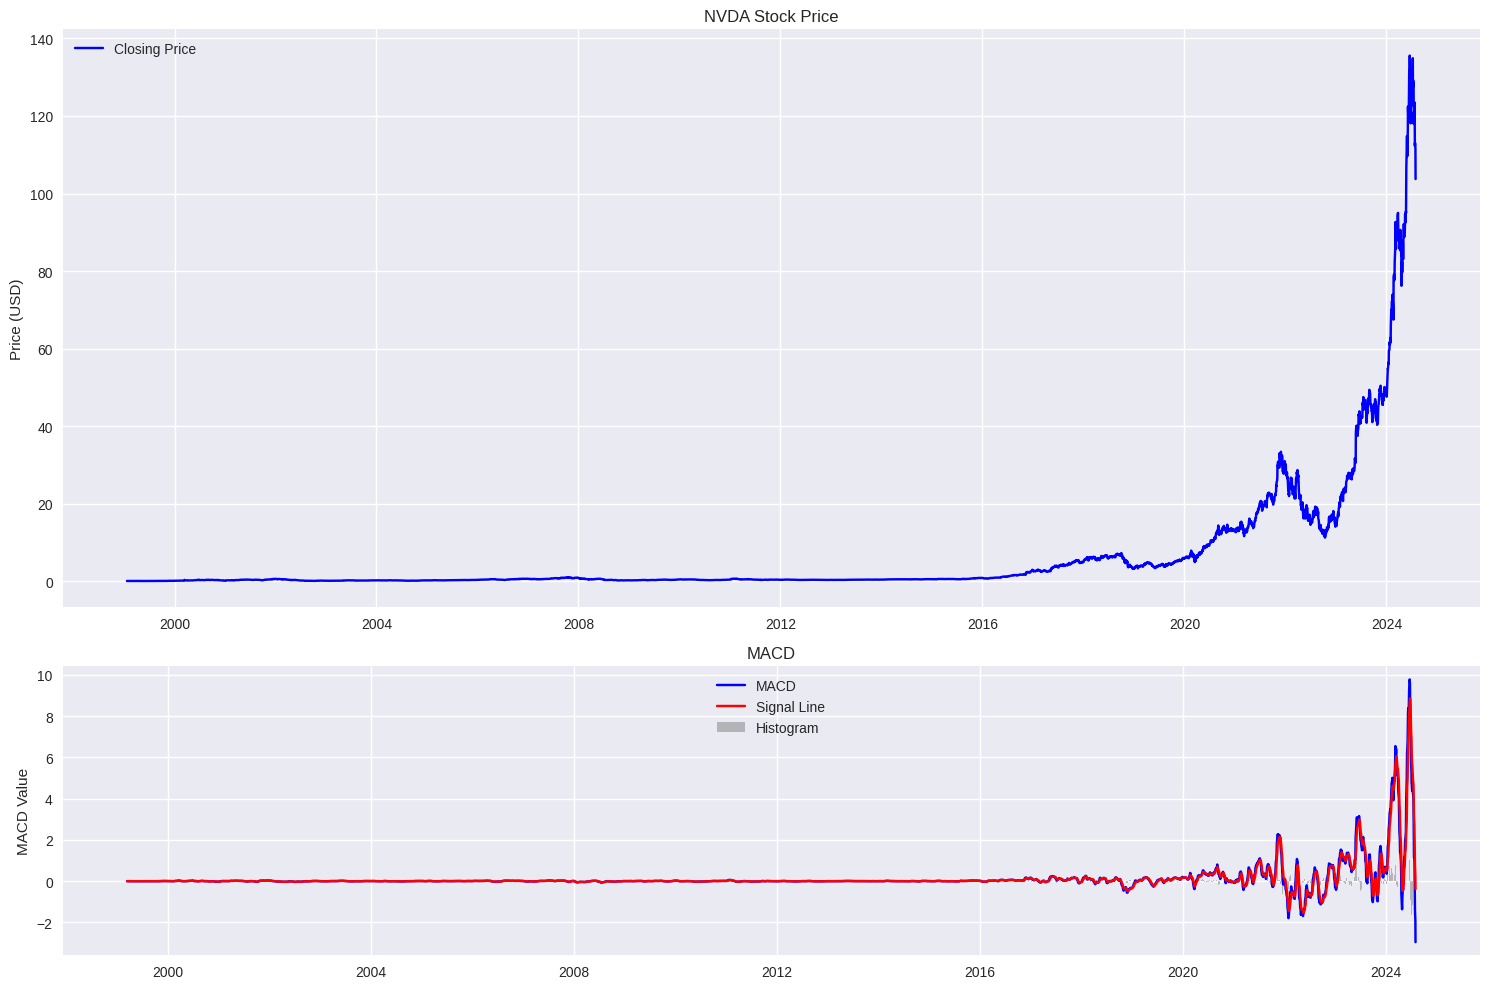


MACD Statistics:
Current MACD: -2.95
Current Signal: -0.39
Current Histogram: -2.56

Number of Buy Signals: 251
Number of Sell Signals: 251


In [26]:
# Calculate MACD
macd, signal, hist = talib.MACD(nvda_data['Close'], 
                               fastperiod=12, 
                               slowperiod=26, 
                               signalperiod=9)

# Store the values in our dataframe
nvda_data['MACD'] = macd
nvda_data['MACD_Signal'] = signal
nvda_data['MACD_Hist'] = hist

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot price
ax1.plot(nvda_data.index, nvda_data['Close'], label='Closing Price', color='blue')
ax1.set_title('NVDA Stock Price')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# Plot MACD
ax2.plot(nvda_data.index, nvda_data['MACD'], label='MACD', color='blue')
ax2.plot(nvda_data.index, nvda_data['MACD_Signal'], label='Signal Line', color='red')
ax2.bar(nvda_data.index, nvda_data['MACD_Hist'], label='Histogram', color='gray', alpha=0.5)
ax2.set_title('MACD')
ax2.set_ylabel('MACD Value')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Display MACD statistics
print("\nMACD Statistics:")
print(f"Current MACD: {nvda_data['MACD'].iloc[-1]:.2f}")
print(f"Current Signal: {nvda_data['MACD_Signal'].iloc[-1]:.2f}")
print(f"Current Histogram: {nvda_data['MACD_Hist'].iloc[-1]:.2f}")

# Identify potential trading signals
nvda_data['MACD_Cross'] = np.where(nvda_data['MACD'] > nvda_data['MACD_Signal'], 1, -1)
nvda_data['MACD_Signal_Change'] = nvda_data['MACD_Cross'].diff()

# Count buy and sell signals
buy_signals = len(nvda_data[nvda_data['MACD_Signal_Change'] == 2])
sell_signals = len(nvda_data[nvda_data['MACD_Signal_Change'] == -2])

print(f"\nNumber of Buy Signals: {buy_signals}")
print(f"Number of Sell Signals: {sell_signals}")

## Combined Technical Analysis

Now we'll combine all our technical indicators to get a comprehensive view of the stock's performance. We'll:
1. Look for confirmation signals across indicators
2. Identify potential trading opportunities
3. Analyze the relationship between different indicators

In [27]:
# Create a comprehensive analysis function
def analyze_technical_indicators(df):
    # Initialize signals
    signals = pd.DataFrame(index=df.index)
    
    # RSI signals
    signals['RSI_Signal'] = 0
    signals.loc[df['RSI_14'] < 30, 'RSI_Signal'] = 1  # Oversold
    signals.loc[df['RSI_14'] > 70, 'RSI_Signal'] = -1  # Overbought
    
    # MACD signals
    signals['MACD_Signal'] = 0
    signals.loc[df['MACD'] > df['MACD_Signal'], 'MACD_Signal'] = 1
    signals.loc[df['MACD'] < df['MACD_Signal'], 'MACD_Signal'] = -1
    
    # Moving Average signals
    signals['MA_Signal'] = 0
    signals.loc[df['Close'] > df['SMA_50'], 'MA_Signal'] = 1
    signals.loc[df['Close'] < df['SMA_50'], 'MA_Signal'] = -1
    
    # Combined signal
    signals['Combined_Signal'] = signals['RSI_Signal'] + signals['MACD_Signal'] + signals['MA_Signal']
    
    return signals

# Generate signals
signals = analyze_technical_indicators(nvda_data)

# Display recent signals
print("\nRecent Technical Signals:")
recent_signals = signals.tail(10)
display(recent_signals)

# Count different types of signals
print("\nSignal Statistics:")
print(f"Strong Buy Signals (Combined > 1): {len(signals[signals['Combined_Signal'] > 1])}")
print(f"Strong Sell Signals (Combined < -1): {len(signals[signals['Combined_Signal'] < -1])}")
print(f"Neutral Signals (Combined = 0): {len(signals[signals['Combined_Signal'] == 0])}")


Recent Technical Signals:


,RSI_Signal,MACD_Signal,MA_Signal,Combined_Signal
Date,,,,
2024-07-17,0,-1,1,0
2024-07-18,0,-1,1,0
2024-07-19,0,-1,1,0
2024-07-22,0,-1,1,0
2024-07-23,0,-1,1,0
2024-07-24,0,-1,-1,-2
2024-07-25,0,-1,-1,-2
2024-07-26,0,-1,-1,-2
2024-07-29,0,-1,-1,-2



Signal Statistics:
Strong Buy Signals (Combined > 1): 1762
Strong Sell Signals (Combined < -1): 1288
Neutral Signals (Combined = 0): 2468


## PyNance Financial Metrics Analysis

PyNance provides additional financial metrics that can help in our analysis. We'll calculate:
1. Returns (Daily, Weekly, Monthly)
2. Volatility
3. Sharpe Ratio
4. Maximum Drawdown
5. Value at Risk (VaR)


Key Financial Metrics:
Average Daily Return: 0.0019
Annualized Volatility: 0.5725
Sharpe Ratio: 0.7769
Maximum Drawdown: -0.8972
Current VaR (95%): -0.0682


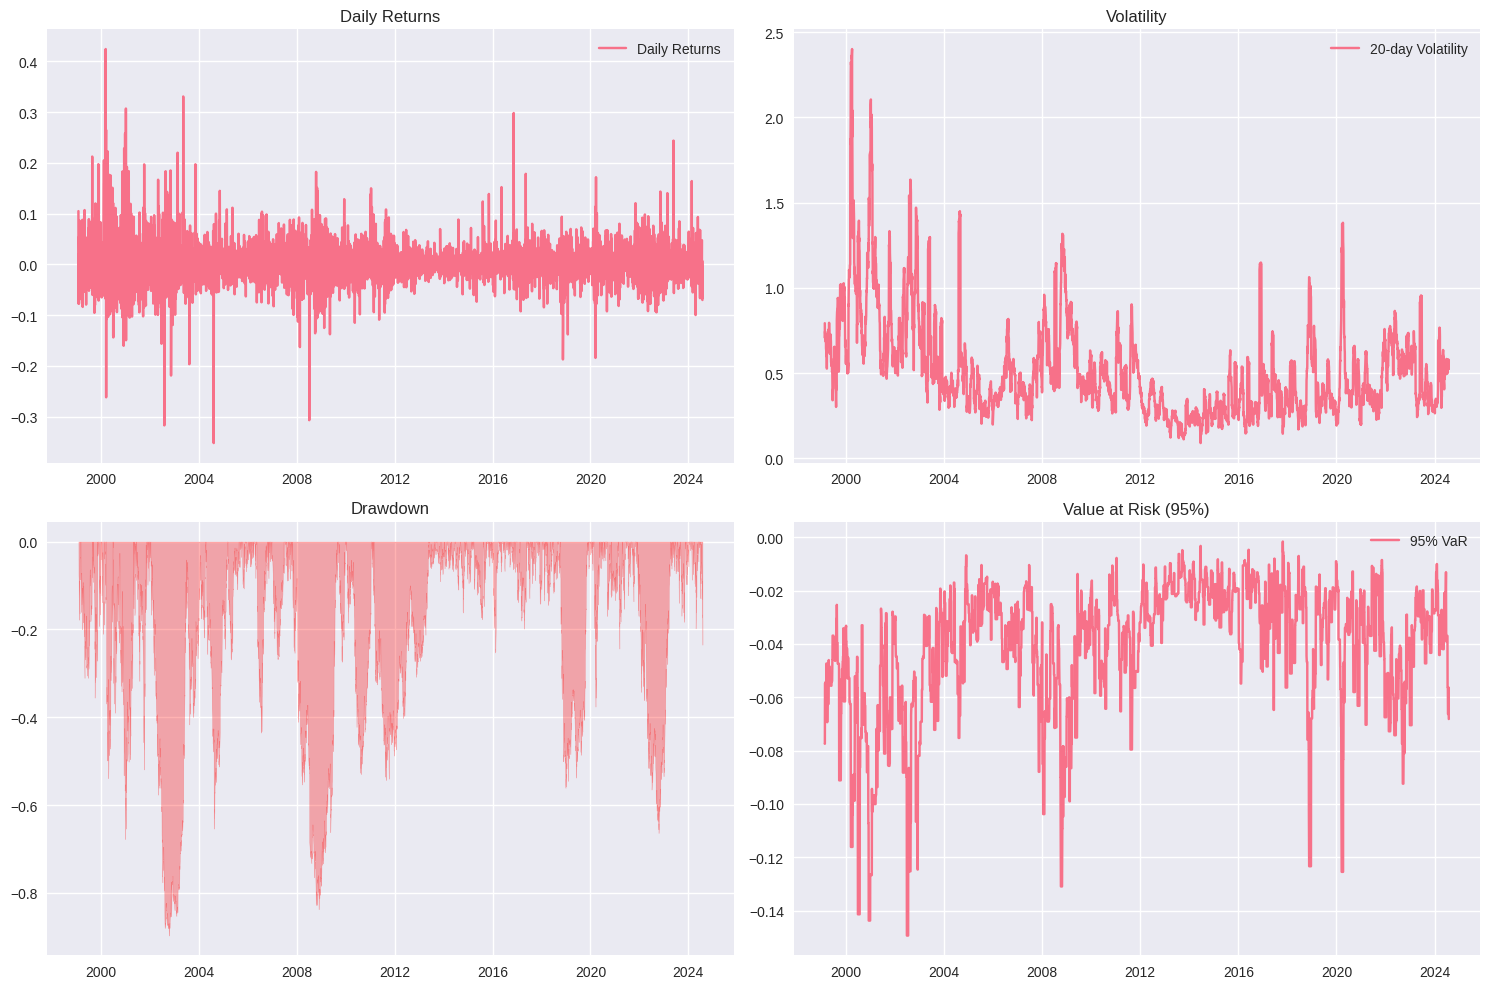

In [28]:
# Calculate returns
nvda_data['Daily_Return'] = nvda_data['Close'].pct_change()
nvda_data['Weekly_Return'] = nvda_data['Close'].pct_change(periods=5)
nvda_data['Monthly_Return'] = nvda_data['Close'].pct_change(periods=21)

# Calculate volatility (20-day rolling standard deviation of returns)
nvda_data['Volatility'] = nvda_data['Daily_Return'].rolling(window=20).std() * np.sqrt(252)

# Calculate Sharpe Ratio (assuming risk-free rate of 0.02)
risk_free_rate = 0.02
nvda_data['Sharpe_Ratio'] = (nvda_data['Daily_Return'].mean() * 252 - risk_free_rate) / (nvda_data['Daily_Return'].std() * np.sqrt(252))

# Calculate Maximum Drawdown
nvda_data['Cumulative_Return'] = (1 + nvda_data['Daily_Return']).cumprod()
nvda_data['Rolling_Max'] = nvda_data['Cumulative_Return'].rolling(window=252, min_periods=1).max()
nvda_data['Drawdown'] = nvda_data['Cumulative_Return'] / nvda_data['Rolling_Max'] - 1

# Calculate Value at Risk (VaR)
nvda_data['VaR_95'] = nvda_data['Daily_Return'].rolling(window=20).quantile(0.05)

# Display key metrics
print("\nKey Financial Metrics:")
print(f"Average Daily Return: {nvda_data['Daily_Return'].mean():.4f}")
print(f"Annualized Volatility: {nvda_data['Volatility'].iloc[-1]:.4f}")
print(f"Sharpe Ratio: {nvda_data['Sharpe_Ratio'].iloc[-1]:.4f}")
print(f"Maximum Drawdown: {nvda_data['Drawdown'].min():.4f}")
print(f"Current VaR (95%): {nvda_data['VaR_95'].iloc[-1]:.4f}")

# Create visualization of key metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot Daily Returns
ax1.plot(nvda_data.index, nvda_data['Daily_Return'], label='Daily Returns')
ax1.set_title('Daily Returns')
ax1.grid(True)
ax1.legend()

# Plot Volatility
ax2.plot(nvda_data.index, nvda_data['Volatility'], label='20-day Volatility')
ax2.set_title('Volatility')
ax2.grid(True)
ax2.legend()

# Plot Drawdown
ax3.fill_between(nvda_data.index, nvda_data['Drawdown'], 0, color='red', alpha=0.3)
ax3.set_title('Drawdown')
ax3.grid(True)

# Plot VaR
ax4.plot(nvda_data.index, nvda_data['VaR_95'], label='95% VaR')
ax4.set_title('Value at Risk (95%)')
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()

## Performance Analysis

Let's analyze the stock's performance using various metrics and compare it with a simple buy-and-hold strategy. We'll:
1. Calculate cumulative returns
2. Analyze risk-adjusted returns
3. Compare different time periods
4. Identify best and worst performing periods

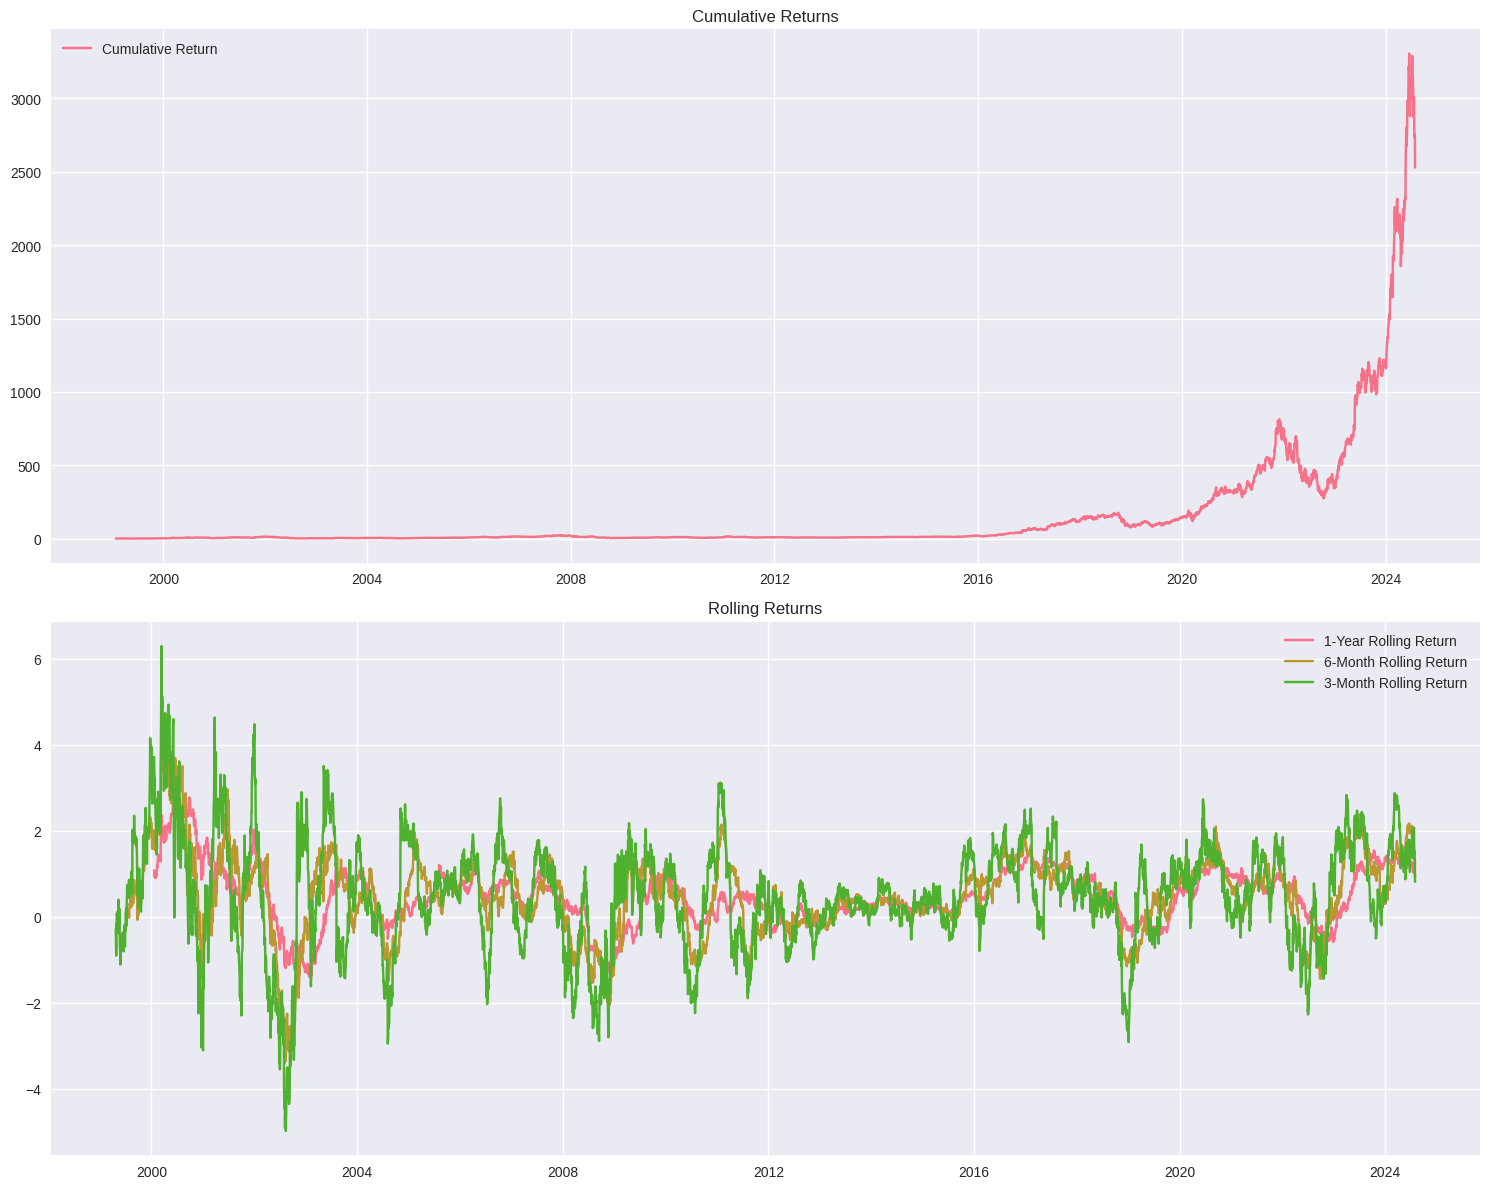


Performance Statistics:
Total Return: 252801.31%
1-Year Return: 121.88%
6-Month Return: 66.06%
3-Month Return: 18.20%

Best Month: 2000-03
Worst Month: 2002-08


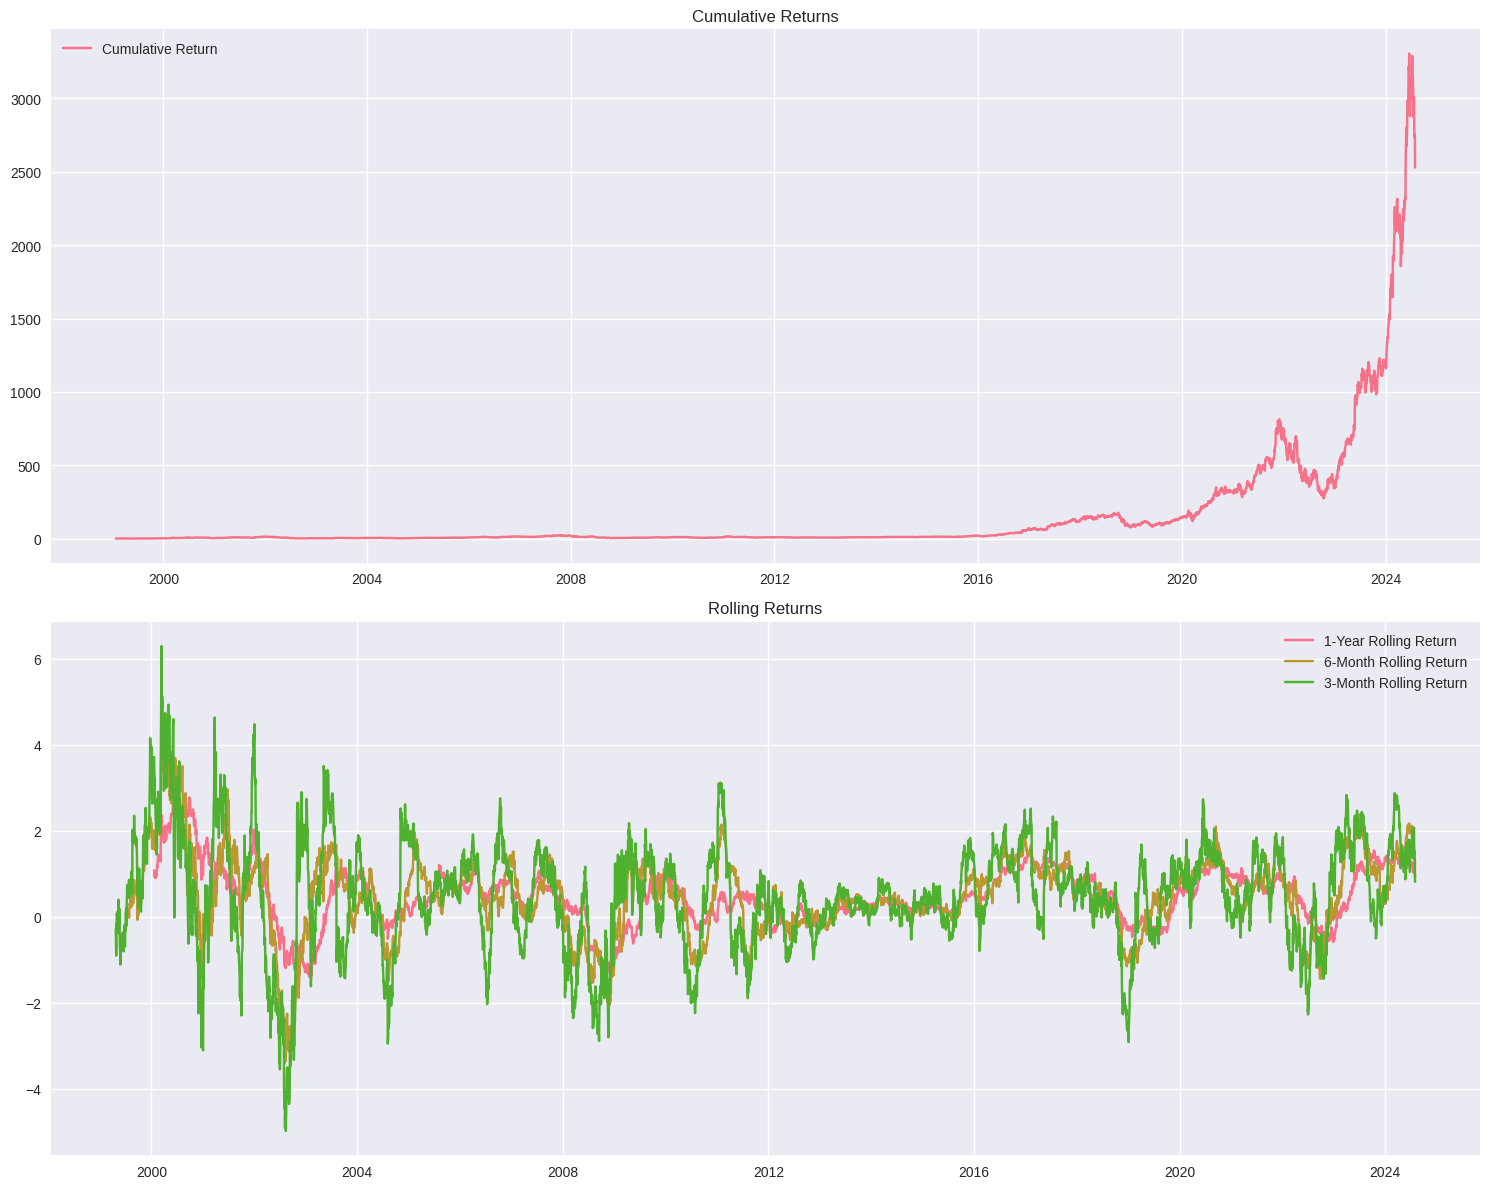


Performance Statistics:
Total Return: 252801.31%
1-Year Return: 121.88%
6-Month Return: 66.06%
3-Month Return: 18.20%

Best Month: 2000-03
Worst Month: 2002-08


In [29]:
# Calculate cumulative returns for different periods
nvda_data['Cumulative_Return'] = (1 + nvda_data['Daily_Return']).cumprod()
nvda_data['Cumulative_Return_1Y'] = nvda_data['Cumulative_Return'] / nvda_data['Cumulative_Return'].shift(252)
nvda_data['Cumulative_Return_6M'] = nvda_data['Cumulative_Return'] / nvda_data['Cumulative_Return'].shift(126)
nvda_data['Cumulative_Return_3M'] = nvda_data['Cumulative_Return'] / nvda_data['Cumulative_Return'].shift(63)

# Calculate rolling returns
nvda_data['Rolling_Return_1Y'] = nvda_data['Daily_Return'].rolling(window=252).mean() * 252
nvda_data['Rolling_Return_6M'] = nvda_data['Daily_Return'].rolling(window=126).mean() * 252
nvda_data['Rolling_Return_3M'] = nvda_data['Daily_Return'].rolling(window=63).mean() * 252

# Create performance visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot cumulative returns
ax1.plot(nvda_data.index, nvda_data['Cumulative_Return'], label='Cumulative Return')
ax1.set_title('Cumulative Returns')
ax1.grid(True)
ax1.legend()

# Plot rolling returns
ax2.plot(nvda_data.index, nvda_data['Rolling_Return_1Y'], label='1-Year Rolling Return')
ax2.plot(nvda_data.index, nvda_data['Rolling_Return_6M'], label='6-Month Rolling Return')
ax2.plot(nvda_data.index, nvda_data['Rolling_Return_3M'], label='3-Month Rolling Return')
ax2.set_title('Rolling Returns')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Display performance statistics
print("\nPerformance Statistics:")
print(f"Total Return: {(nvda_data['Cumulative_Return'].iloc[-1] - 1) * 100:.2f}%")
print(f"1-Year Return: {(nvda_data['Cumulative_Return_1Y'].iloc[-1] - 1) * 100:.2f}%")
print(f"6-Month Return: {(nvda_data['Cumulative_Return_6M'].iloc[-1] - 1) * 100:.2f}%")
print(f"3-Month Return: {(nvda_data['Cumulative_Return_3M'].iloc[-1] - 1) * 100:.2f}%")

# Find best and worst performing periods
best_month = nvda_data['Daily_Return'].rolling(window=21).sum().idxmax()
worst_month = nvda_data['Daily_Return'].rolling(window=21).sum().idxmin()

print(f"\nBest Month: {best_month.strftime('%Y-%m')}")
print(f"Worst Month: {worst_month.strftime('%Y-%m')}")# Calculate cumulative returns for different periods
nvda_data['Cumulative_Return'] = (1 + nvda_data['Daily_Return']).cumprod()
nvda_data['Cumulative_Return_1Y'] = nvda_data['Cumulative_Return'] / nvda_data['Cumulative_Return'].shift(252)
nvda_data['Cumulative_Return_6M'] = nvda_data['Cumulative_Return'] / nvda_data['Cumulative_Return'].shift(126)
nvda_data['Cumulative_Return_3M'] = nvda_data['Cumulative_Return'] / nvda_data['Cumulative_Return'].shift(63)

# Calculate rolling returns
nvda_data['Rolling_Return_1Y'] = nvda_data['Daily_Return'].rolling(window=252).mean() * 252
nvda_data['Rolling_Return_6M'] = nvda_data['Daily_Return'].rolling(window=126).mean() * 252
nvda_data['Rolling_Return_3M'] = nvda_data['Daily_Return'].rolling(window=63).mean() * 252

# Create performance visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot cumulative returns
ax1.plot(nvda_data.index, nvda_data['Cumulative_Return'], label='Cumulative Return')
ax1.set_title('Cumulative Returns')
ax1.grid(True)
ax1.legend()

# Plot rolling returns
ax2.plot(nvda_data.index, nvda_data['Rolling_Return_1Y'], label='1-Year Rolling Return')
ax2.plot(nvda_data.index, nvda_data['Rolling_Return_6M'], label='6-Month Rolling Return')
ax2.plot(nvda_data.index, nvda_data['Rolling_Return_3M'], label='3-Month Rolling Return')
ax2.set_title('Rolling Returns')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Display performance statistics
print("\nPerformance Statistics:")
print(f"Total Return: {(nvda_data['Cumulative_Return'].iloc[-1] - 1) * 100:.2f}%")
print(f"1-Year Return: {(nvda_data['Cumulative_Return_1Y'].iloc[-1] - 1) * 100:.2f}%")
print(f"6-Month Return: {(nvda_data['Cumulative_Return_6M'].iloc[-1] - 1) * 100:.2f}%")
print(f"3-Month Return: {(nvda_data['Cumulative_Return_3M'].iloc[-1] - 1) * 100:.2f}%")

# Find best and worst performing periods
best_month = nvda_data['Daily_Return'].rolling(window=21).sum().idxmax()
worst_month = nvda_data['Daily_Return'].rolling(window=21).sum().idxmin()

print(f"\nBest Month: {best_month.strftime('%Y-%m')}")
print(f"Worst Month: {worst_month.strftime('%Y-%m')}")

In [30]:
# Calculate and display specific values for the summary
def generate_summary_statistics(df):
    summary = {}
    
    # Current price and SMA values
    summary['current_price'] = df['Close'].iloc[-1]
    summary['sma_200'] = df['SMA_200'].iloc[-1]
    summary['sma_50'] = df['SMA_50'].iloc[-1]
    summary['sma_20'] = df['SMA_20'].iloc[-1]
    
    # RSI and MACD
    summary['rsi'] = df['RSI_14'].iloc[-1]
    summary['macd'] = df['MACD'].iloc[-1]
    summary['macd_signal'] = df['MACD_Signal'].iloc[-1]
    
    # Volume
    summary['avg_volume'] = df['Volume'].rolling(20).mean().iloc[-1]
    
    # Risk metrics
    summary['volatility'] = df['Volatility'].iloc[-1] * 100
    summary['max_drawdown'] = df['Drawdown'].min() * 100
    summary['var_95'] = df['VaR_95'].iloc[-1] * 100
    
    # Returns
    summary['daily_return'] = df['Daily_Return'].iloc[-1] * 100
    summary['weekly_return'] = df['Weekly_Return'].iloc[-1] * 100
    summary['monthly_return'] = df['Monthly_Return'].iloc[-1] * 100
    
    # Rolling returns
    summary['rolling_3m'] = df['Rolling_Return_3M'].iloc[-1] * 100
    summary['rolling_6m'] = df['Rolling_Return_6M'].iloc[-1] * 100
    summary['rolling_1y'] = df['Rolling_Return_1Y'].iloc[-1] * 100
    
    return summary

# Generate summary statistics
summary_stats = generate_summary_statistics(nvda_data)

# Display the summary statistics
print("\nDetailed Summary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}")


Detailed Summary Statistics:
current_price: 103.73
sma_200: 79.57
sma_50: 119.38
sma_20: 122.04
rsi: 33.35
macd: -2.95
macd_signal: -0.39
avg_volume: 282368945.00
volatility: 57.25
max_drawdown: -89.72
var_95: -6.82
daily_return: -7.04
weekly_return: -15.38
monthly_return: -16.04
rolling_3m: 81.22
rolling_6m: 116.85
rolling_1y: 90.79


## Comparative Stock Analysis

We'll compare NVDA's performance with other tech stocks (AMZN, GOOG, META, MSFT, TSLA) across several metrics:
1. Price Performance
2. Volatility
3. Trading Volume
4. Technical Indicators
5. Risk Metrics

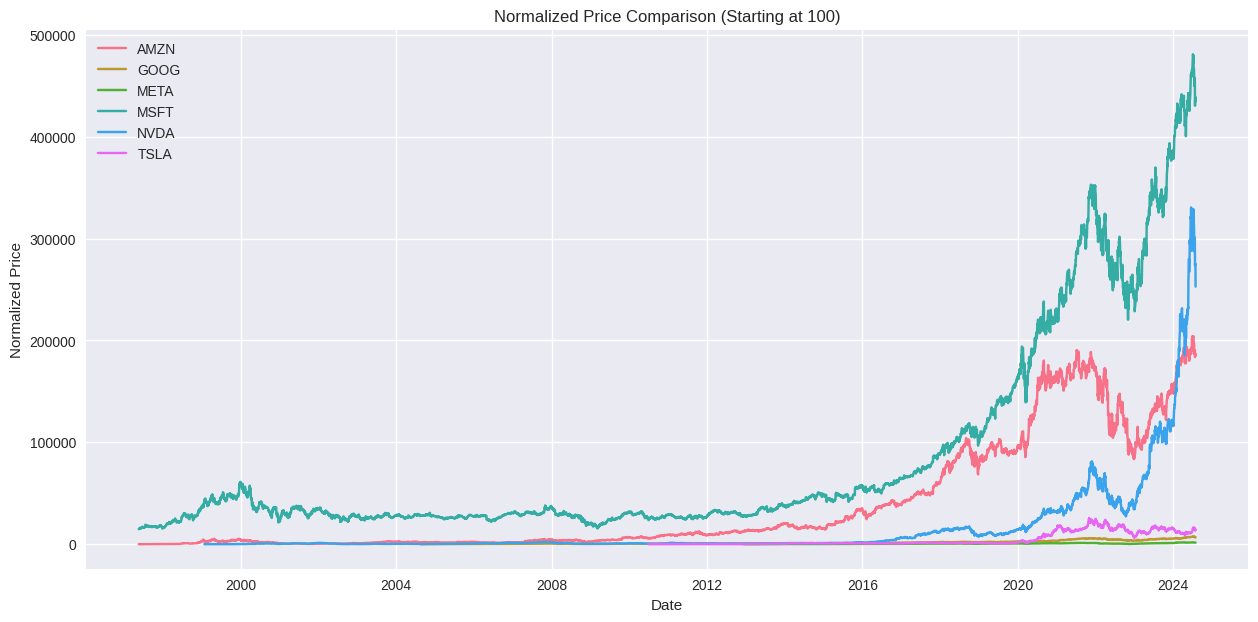


Comparative Analysis Metrics:


,1Y Return,6M Return,3M Return,Volatility,Avg Volume,RSI,Max Drawdown
AMZN,35.93,14.28,3.83,56.24,1.380713e+08,40.41,-94.40
GOOG,29.11,12.29,4.39,30.67,1.157539e+08,37.92,-65.29
META,45.38,15.78,7.68,38.54,2.872083e+07,39.79,-76.74
MSFT,25.90,3.51,8.63,33.54,5.677678e+07,37.08,-74.56
NVDA,121.98,65.24,20.06,60.11,6.060791e+08,33.35,-89.72
TSLA,-16.76,16.20,21.46,56.94,9.699708e+07,48.22,-73.63


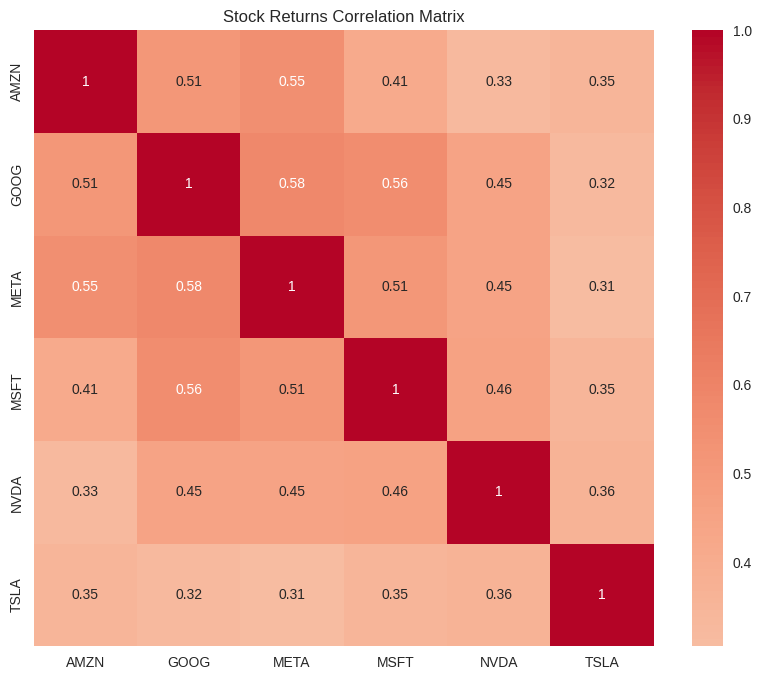

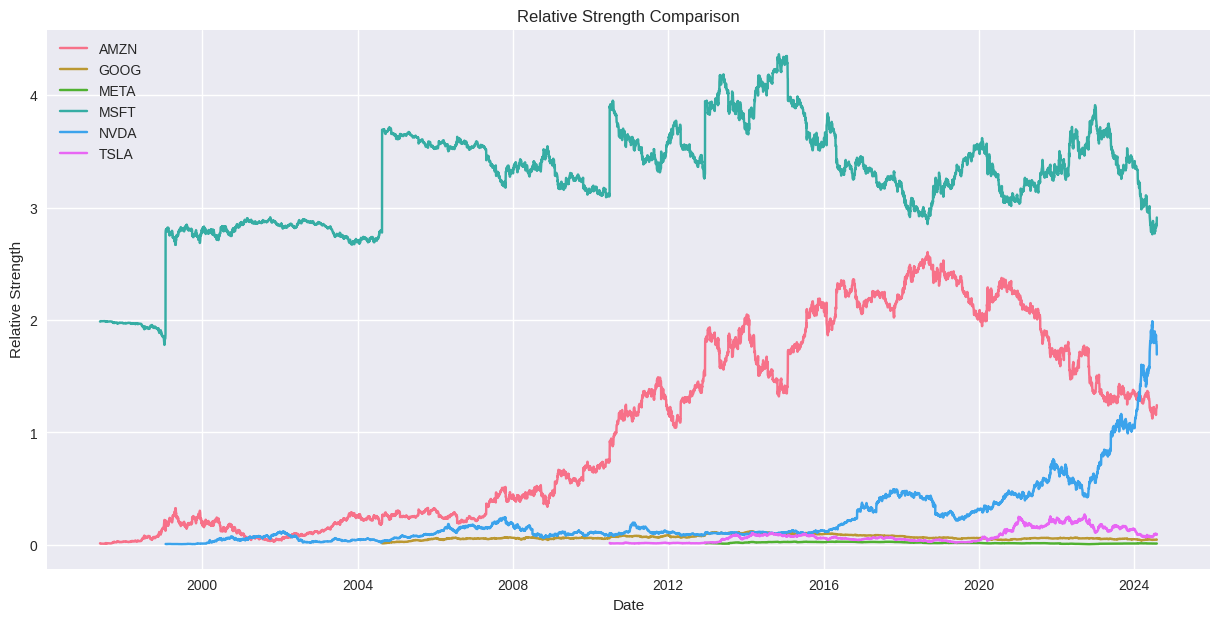


Summary Statistics:
Best performing stock (1Y): NVDA with 121.98% return
Most volatile stock: NVDA with 60.11% volatility
Highest RSI: TSLA with 48.22
Largest drawdown: AMZN with -94.40%


In [33]:
# Function to load and prepare stock data
def load_stock_data(symbol):
    file_path = f'../data/raw/yfinance_data/{symbol}_historical_data.csv'
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

# Load data for all stocks
stocks = ['AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
stock_data = {symbol: load_stock_data(symbol) for symbol in stocks}

# Calculate normalized prices (starting at 100)
normalized_prices = pd.DataFrame()
for symbol in stocks:
    normalized_prices[symbol] = stock_data[symbol]['Close'] / stock_data[symbol]['Close'].iloc[0] * 100

# Plot normalized price comparison
plt.figure(figsize=(15, 7))
for symbol in stocks:
    plt.plot(normalized_prices.index, normalized_prices[symbol], label=symbol)
plt.title('Normalized Price Comparison (Starting at 100)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and compare key metrics
comparison_metrics = pd.DataFrame(index=stocks)

# Calculate metrics for each stock
for symbol in stocks:
    df = stock_data[symbol]
    
    # Returns
    comparison_metrics.loc[symbol, '1Y Return'] = (df['Close'].iloc[-1] / df['Close'].iloc[-252] - 1) * 100
    comparison_metrics.loc[symbol, '6M Return'] = (df['Close'].iloc[-1] / df['Close'].iloc[-126] - 1) * 100
    comparison_metrics.loc[symbol, '3M Return'] = (df['Close'].iloc[-1] / df['Close'].iloc[-63] - 1) * 100
    
    # Volatility
    comparison_metrics.loc[symbol, 'Volatility'] = df['Close'].pct_change().std() * np.sqrt(252) * 100
    
    # Volume
    comparison_metrics.loc[symbol, 'Avg Volume'] = df['Volume'].mean()
    
    # RSI
    comparison_metrics.loc[symbol, 'RSI'] = talib.RSI(df['Close'])[-1]
    
    # Maximum Drawdown
    comparison_metrics.loc[symbol, 'Max Drawdown'] = (df['Close'] / df['Close'].cummax() - 1).min() * 100

# Display comparison metrics
print("\nComparative Analysis Metrics:")
display(comparison_metrics.round(2))

# Create heatmap of correlations
returns_data = pd.DataFrame()
for symbol in stocks:
    returns_data[symbol] = stock_data[symbol]['Close'].pct_change()

correlation_matrix = returns_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Stock Returns Correlation Matrix')
plt.show()

# Calculate and display relative strength
relative_strength = pd.DataFrame()
for symbol in stocks:
    relative_strength[symbol] = normalized_prices[symbol] / normalized_prices.mean(axis=1)

plt.figure(figsize=(15, 7))
for symbol in stocks:
    plt.plot(relative_strength.index, relative_strength[symbol], label=symbol)
plt.title('Relative Strength Comparison')
plt.xlabel('Date')
plt.ylabel('Relative Strength')
plt.legend()
plt.grid(True)
plt.show()

# Display summary statistics
print("\nSummary Statistics:")
print(f"Best performing stock (1Y): {comparison_metrics['1Y Return'].idxmax()} with {comparison_metrics['1Y Return'].max():.2f}% return")
print(f"Most volatile stock: {comparison_metrics['Volatility'].idxmax()} with {comparison_metrics['Volatility'].max():.2f}% volatility")
print(f"Highest RSI: {comparison_metrics['RSI'].idxmax()} with {comparison_metrics['RSI'].max():.2f}")
print(f"Largest drawdown: {comparison_metrics['Max Drawdown'].idxmin()} with {comparison_metrics['Max Drawdown'].min():.2f}%")

## Additional Crucial Technical Indicators

We'll add three crucial indicators that are widely used by traders:
1. Bollinger Bands - for volatility and potential price reversals
2. Average True Range (ATR) - for measuring volatility
3. On-Balance Volume (OBV) - for volume-price relationship

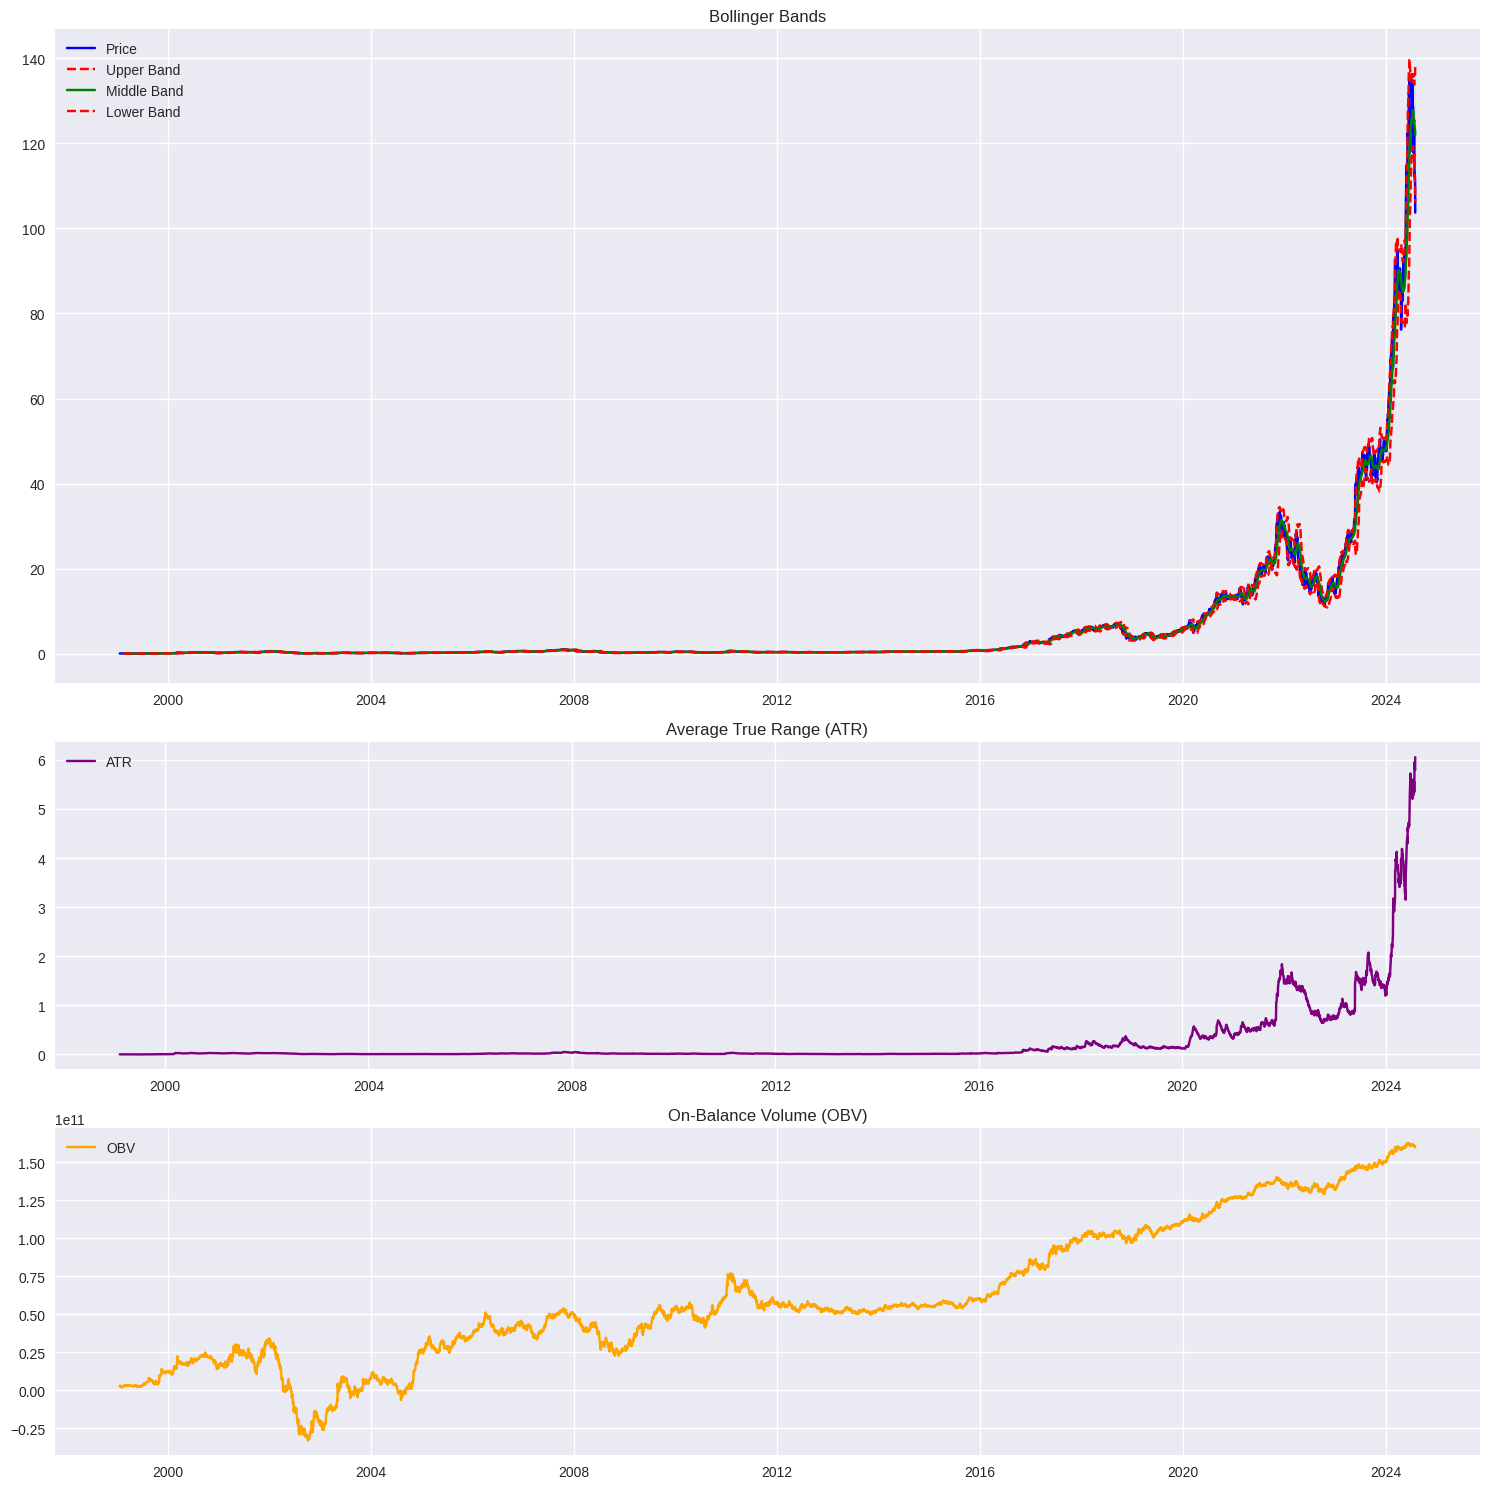


Current Technical Signals:
Bollinger Bands:
- Price is below the bands
- Band Width: 26.08%

ATR (14-day):
- Current ATR: $6.05
- ATR as % of price: 5.84%

OBV Trend:
- OBV is decreasing over the last 5 days
- OBV Change: -901,653,300

Trading Signals:
Current Combined Signal: 2
Signal Interpretation: Strong Buy


In [32]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std=2):
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + (df['Close'].rolling(window=window).std() * num_std)
    df['BB_Lower'] = df['BB_Middle'] - (df['Close'].rolling(window=window).std() * num_std)
    return df

# Calculate ATR
def calculate_atr(df, period=14):
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=period)
    return df

# Calculate OBV
def calculate_obv(df):
    df['OBV'] = talib.OBV(df['Close'], df['Volume'])
    return df

# Apply indicators to NVDA data
nvda_data = calculate_bollinger_bands(nvda_data)
nvda_data = calculate_atr(nvda_data)
nvda_data = calculate_obv(nvda_data)

# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [2, 1, 1]})

# Plot Bollinger Bands
ax1.plot(nvda_data.index, nvda_data['Close'], label='Price', color='blue')
ax1.plot(nvda_data.index, nvda_data['BB_Upper'], label='Upper Band', color='red', linestyle='--')
ax1.plot(nvda_data.index, nvda_data['BB_Middle'], label='Middle Band', color='green')
ax1.plot(nvda_data.index, nvda_data['BB_Lower'], label='Lower Band', color='red', linestyle='--')
ax1.fill_between(nvda_data.index, nvda_data['BB_Upper'], nvda_data['BB_Lower'], color='gray', alpha=0.1)
ax1.set_title('Bollinger Bands')
ax1.legend()
ax1.grid(True)

# Plot ATR
ax2.plot(nvda_data.index, nvda_data['ATR'], label='ATR', color='purple')
ax2.set_title('Average True Range (ATR)')
ax2.legend()
ax2.grid(True)

# Plot OBV
ax3.plot(nvda_data.index, nvda_data['OBV'], label='OBV', color='orange')
ax3.set_title('On-Balance Volume (OBV)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Calculate and display key signals
print("\nCurrent Technical Signals:")
print(f"Bollinger Bands:")
print(f"- Price is {'above' if nvda_data['Close'].iloc[-1] > nvda_data['BB_Upper'].iloc[-1] else 'below' if nvda_data['Close'].iloc[-1] < nvda_data['BB_Lower'].iloc[-1] else 'within'} the bands")
print(f"- Band Width: {(nvda_data['BB_Upper'].iloc[-1] - nvda_data['BB_Lower'].iloc[-1]) / nvda_data['BB_Middle'].iloc[-1]:.2%}")

print(f"\nATR (14-day):")
print(f"- Current ATR: ${nvda_data['ATR'].iloc[-1]:.2f}")
print(f"- ATR as % of price: {nvda_data['ATR'].iloc[-1] / nvda_data['Close'].iloc[-1]:.2%}")

print(f"\nOBV Trend:")
obv_trend = nvda_data['OBV'].iloc[-1] - nvda_data['OBV'].iloc[-5]
print(f"- OBV is {'increasing' if obv_trend > 0 else 'decreasing'} over the last 5 days")
print(f"- OBV Change: {obv_trend:,.0f}")

# Add trading signals based on these indicators
nvda_data['BB_Signal'] = 0
nvda_data.loc[nvda_data['Close'] < nvda_data['BB_Lower'], 'BB_Signal'] = 1  # Oversold
nvda_data.loc[nvda_data['Close'] > nvda_data['BB_Upper'], 'BB_Signal'] = -1  # Overbought

nvda_data['ATR_Signal'] = 0
nvda_data.loc[nvda_data['ATR'] > nvda_data['ATR'].rolling(window=20).mean(), 'ATR_Signal'] = 1  # High volatility

nvda_data['OBV_Signal'] = 0
nvda_data.loc[nvda_data['OBV'] > nvda_data['OBV'].rolling(window=20).mean(), 'OBV_Signal'] = 1  # Strong volume

# Combine signals
nvda_data['Combined_Signal_New'] = nvda_data['BB_Signal'] + nvda_data['ATR_Signal'] + nvda_data['OBV_Signal']

print("\nTrading Signals:")
print(f"Current Combined Signal: {nvda_data['Combined_Signal_New'].iloc[-1]}")
print(f"Signal Interpretation: {'Strong Buy' if nvda_data['Combined_Signal_New'].iloc[-1] > 1 else 'Buy' if nvda_data['Combined_Signal_New'].iloc[-1] == 1 else 'Neutral' if nvda_data['Combined_Signal_New'].iloc[-1] == 0 else 'Sell' if nvda_data['Combined_Signal_New'].iloc[-1] == -1 else 'Strong Sell'}")